In [1]:
%matplotlib inline

import os
import re
import numpy as np
import pandas as pd
import gensim
from collections import Counter
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
from gensim.corpora import Dictionary
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score

# modeling imports
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics

# store models
import pickle

# visualization imports
from sklearn.metrics import confusion_matrix
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
sns.set()

# database imports
from sqlalchemy import create_engine
from sqlalchemy_utils import create_database, database_exists, drop_database
import psycopg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

[nltk_data] Downloading package punkt to /home/clutch/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/sqlalchemy/sql/functions.py:68: SAWarning: The GenericFunction 'array_agg' is already registered and is going to be overriden.
  "is going to be overriden.".format(identifier))


### Locate PostgreSQL Key and Connect to DB

In [2]:
# # using function from "Keeping API Keys Secret.ipynb"
# # by https://github.com/dylburger
# def get_file_contents(filename):
#     """ 
#     Given a filename,
#     return the contents of that file
#     """
#     try:
#         with open(filename, 'r') as f:
#             # assumed file is a single line with key
#             return f.read().strip()
#     except FileNotFoundError:
#         print("'%s' file not found" % filename)

In [3]:
# # define a database name (we're using a dataset on births, so we'll call it birth_db)
# # Set your postgres username
# dbname = 'insight_db'
# username = 'postgres' # change this to your username
# password = get_file_contents('../keys/psql_key')

In [4]:
# # 'engine' is a connection to a database
# engine = create_engine('postgres://%s:%s@localhost/%s'%(username,password,dbname))
# # load sql_magic so we can write SQL in Jupyter Notebooks
# %load_ext sql_magic

# # setup SQL connection to the postgreSQL engine we created
# %config SQL.conn_name = 'engine'
# print(engine.url)

In [5]:
# # connect to make queries using psycopg2
# con = psycopg2.connect(database = dbname, host = 'localhost', user = username, password = password)
# con.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)

In [6]:
# # load data from videos table into dataframe
# data_df = pd.read_sql('SELECT * from videos', con=con)
# data_df.drop(columns=['id', 'upload_date', 'duration', 
#                       'view_count', 'likes', 'dislikes', 
#                       'video', 'thumbnail'], inplace=True)
# #data_df.groupby('primary_category').video_id.count()

In [7]:
from_csv_filename = 'data/csv_files/summarized_with_tools.csv'

In [8]:
data_df = pd.read_csv(from_csv_filename, sep=',')

In [9]:
data_df.head()

,video_id,title,subtitles,primary_category,text,txt_len,summary,summary_len,prcnt_reduce,mentioned_tools,recommended_tools
0,0Aip_xxpia4,How to install carpet tiles,were going to replace this tired old wall-to-w...,carpet_flooring,Interface do a product called tactiles which a...,2183,"If you're able to :), use a mover disc for fuc...",398,81.768209,"['chalk', 'square']","['duckbill napping shears', 'carpet knife', 's..."
1,1rAg4wW8ta0,How to carpet van interior panels - diy van ca...,all right well today Im going to be covering t...,carpet_flooring,Just shows you don't need a fancy arsed worksh...,2711,"How did you fix the panels, 🤙, screwed through...",476,82.441903,['square'],"['duckbill napping shears', 'carpet knife', 's..."
2,2qAqFuo801U,Honda accord carpet removal install,whats going on guys today in my 1999 Accord Se...,carpet_flooring,"The green stuff is sound dampening stuff., A l...",3825,"It fits and is the modern honda ""h"", i never n...",711,81.411765,['punch'],"['duckbill napping shears', 'carpet knife', 's..."
3,3-3gmCZm34E,Diy jon boat interior boat carpet on a budget,hey guys Anthony Jones here with the Top Gun J...,carpet_flooring,"Pretty Jon., I appreciate it greatly!, I subcr...",20949,""" im ded, u alreedy kno cuzin, ""subcribe"", max...",536,97.441405,"['hammer', 'square']","['duckbill napping shears', 'carpet knife', 's..."
4,3jvAV5TanIM,How to install laminate flooring laying your f...,are you installing your own laminate flooring ...,carpet_flooring,", Why did u high 5 your wife. She did nothing ...",13879,Can you lay timber flooring on top of timber f...,558,95.979537,"['pencil', 'jigsaw', 'spacers', 'square', 'saw...","['heavy weight carpet roller', 'work gloves', ..."


In [10]:
data_df.video_id.count()

1037

## Use Term Frequency, Inverse Document Frequency (TF-IDF) to extract features

In [11]:
cols = ['primary_category', 'title']
df = data_df[cols].copy()

In [12]:
#df.drop_duplicates(subset='title', keep="last", inplace=True)

In [13]:
df['category_id'] = df['primary_category'].factorize()[0]

In [14]:
category_id_df = df[['primary_category', 'category_id']].drop_duplicates().sort_values('category_id')

In [15]:
category_to_id = dict(category_id_df.values)

In [16]:
id_to_category = dict(category_id_df[['category_id', 'primary_category']].values)

In [17]:
df.head()

,primary_category,title,category_id
0,carpet_flooring,How to install carpet tiles,0
1,carpet_flooring,How to carpet van interior panels - diy van ca...,0
2,carpet_flooring,Honda accord carpet removal install,0
3,carpet_flooring,Diy jon boat interior boat carpet on a budget,0
4,carpet_flooring,How to install laminate flooring laying your f...,0


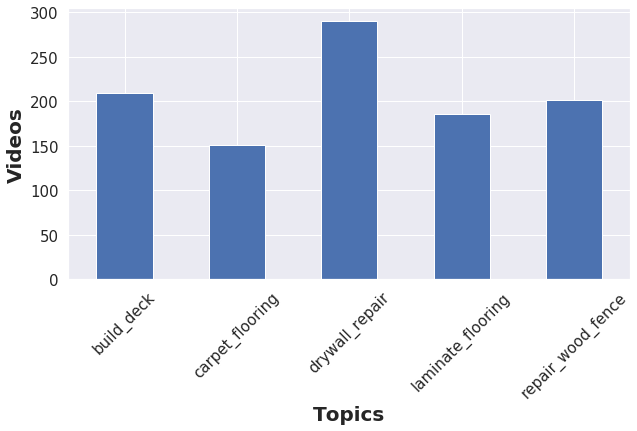

In [35]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 25}

matplotlib.rc('font', **font)
fig = plt.figure(figsize=(8,6))
df.groupby('primary_category').title.count().plot.bar(ylim=0)
plt.xlabel('Topics', fontsize=20,fontweight="bold")
plt.ylabel('Videos', fontsize=20,fontweight="bold")
plt.yticks(fontsize=15)
plt.xticks(rotation=45, fontsize=15)
plt.tight_layout()
fig.set_size_inches(10, 7)
fig.savefig('data/topic_model_counts.png', dpi=200)
plt.show()

In [36]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='UTF-8', 
                        ngram_range=(1, 2), stop_words='english')

In [37]:
features = tfidf.fit_transform(df.title).toarray()
labels = df.category_id
features.shape

(1037, 314)

### Find terms that are most correlated with each of the Primary Categories

In [38]:
N = 2
for primary_category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(primary_category))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'build_deck':
  . Most correlated unigrams:
. build
. deck
  . Most correlated bigrams:
. deck building
. build deck
# 'carpet_flooring':
  . Most correlated unigrams:
. transition
. carpet
  . Most correlated bigrams:
. carpet installation
. install carpet
# 'drywall_repair':
  . Most correlated unigrams:
. repair
. drywall
  . Most correlated bigrams:
. repair drywall
. drywall repair
# 'laminate_flooring':
  . Most correlated unigrams:
. flooring
. laminate
  . Most correlated bigrams:
. install laminate
. laminate flooring
# 'repair_wood_fence':
  . Most correlated unigrams:
. post
. fence
  . Most correlated bigrams:
. wood fence
. fence post


### Train supervised classifier: transform titles into vector of numbers using TF-IDF weighted vectors

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['primary_category'], random_state = 42)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [40]:
print(clf.predict(count_vect.transform(["How to install laminate flooring."])))

['laminate_flooring']


In [41]:
print(clf.predict(count_vect.transform(["How to remove carpet and install laminate flooring."])))

['laminate_flooring']


### Model Selection

In [42]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    SVC(probability=True, gamma='auto'),
    MultinomialNB(alpha=0.5, fit_prior=True),
    LogisticRegression(random_state=42, solver='lbfgs', multi_class='auto'),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

In [43]:
cv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Empty DataFrame

In [44]:
for model in models:
    model_name = model.__class__.__name__
    log_losses = cross_val_score(model, features, labels, scoring='neg_log_loss', cv=CV)
    for fold_idx, log_loss in enumerate(log_losses):
        entries.append((model_name, fold_idx, log_loss))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'neg_log_loss'])

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


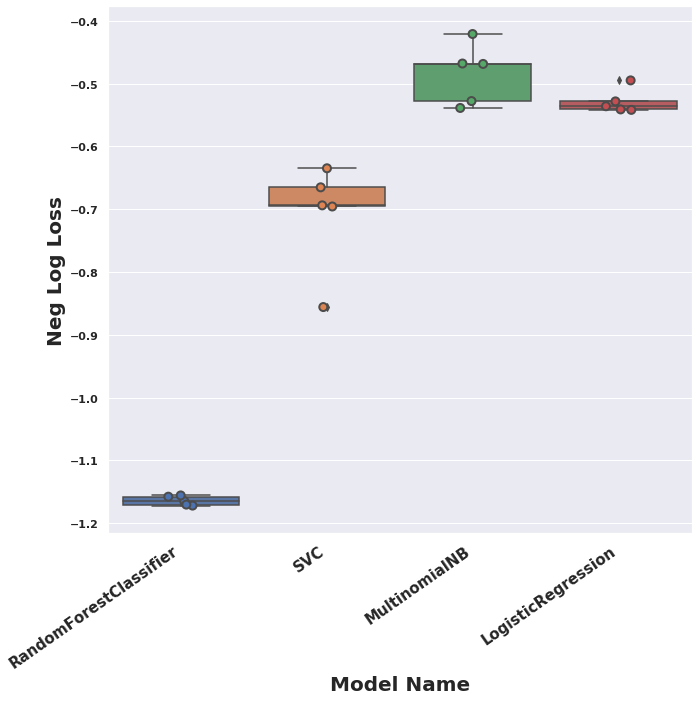

In [45]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x='model_name', y='neg_log_loss', data=cv_df)
sns.stripplot(x='model_name', y='neg_log_loss', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
sns.set(font_scale=1.25)
plt.xticks(rotation=35, fontsize=15, ha='right')
sns.set_style("whitegrid")
plt.ylabel('Neg Log Loss', fontsize=20, fontweight="bold")
plt.xlabel('Model Name', fontsize=20, fontweight="bold")
plt.tight_layout()
fig.set_size_inches(10, 10)
fig.savefig('data/classification_model_selection.png', dpi=100)
plt.show()

In [46]:
cv_df.groupby('model_name').neg_log_loss.mean()

model_name
LogisticRegression       -0.528314
MultinomialNB            -0.484710
RandomForestClassifier   -1.164369
SVC                      -0.709058
Name: neg_log_loss, dtype: float64

In [55]:
model = MultinomialNB(alpha=0.5, fit_prior=True)
#model = LogisticRegression(random_state=42, solver='lbfgs', multi_class='auto')
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, 
                                                                                 labels, 
                                                                                 df.index, 
                                                                                 test_size=0.33, 
                                                                                 random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

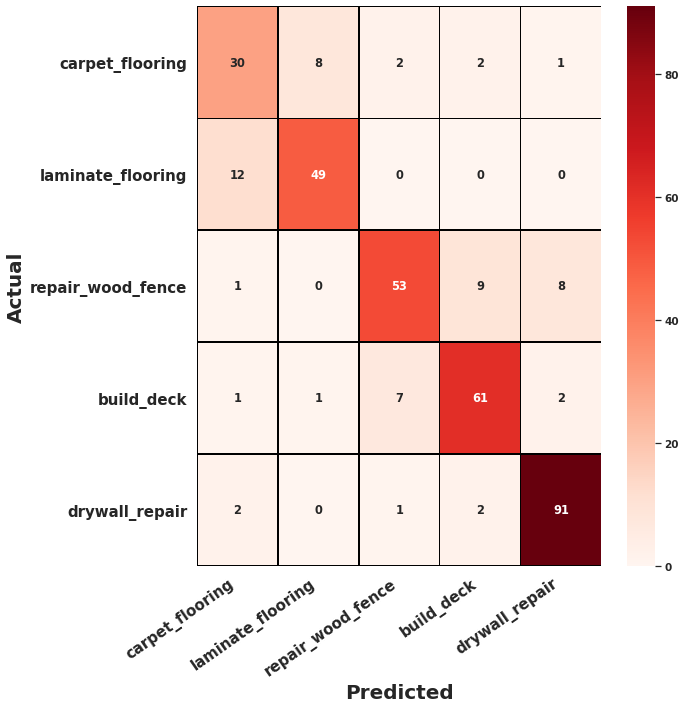

In [56]:
conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Reds", linecolor='Black', linewidths=.5,
            xticklabels=category_id_df.primary_category.values, yticklabels=category_id_df.primary_category.values)
sns.set(font_scale=.95)
sns.set_style("white")


plt.ylabel('Actual', fontsize=20, fontweight="bold")
plt.xlabel('Predicted', fontsize=20, fontweight="bold")
plt.xticks(rotation=35, fontsize=15, ha='right')
plt.yticks(rotation=360, fontsize=15)
plt.tight_layout()
fig.set_size_inches(10, 10)
plt.savefig('data/topic_modeling_classification.png', dpi=200)
plt.show()

In [57]:
from IPython.display import display
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] > 5:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['primary_category', 'title']])
            print('')

'laminate_flooring' predicted as 'carpet_flooring' : 12 examples.


,primary_category,title
330,laminate_flooring,How to install vinyl flooring
200,laminate_flooring,Diy rv reflooring with a flush slide-out
299,laminate_flooring,How to install vinyl floor sheet vinyl. easy h...
312,laminate_flooring,How not to install wood floor
196,laminate_flooring,How install vinyl plank from home depot hd eng...
202,laminate_flooring,D.i.y. install underlayment for vinyl flooring...
247,laminate_flooring,Newbies install vinyl snap-in flooring
264,laminate_flooring,How to install vinyl flooring simple steps to ...
240,laminate_flooring,How to install a wood floor on top of carpet
320,laminate_flooring,How to install wood flooring - doorways room t...



'carpet_flooring' predicted as 'laminate_flooring' : 8 examples.


,primary_category,title
103,carpet_flooring,Diy rv laminate flooring install custom mods ~...
27,carpet_flooring,Learn how to install hardwood floors diy projects
45,carpet_flooring,Laminate over carpet rental friendly
144,carpet_flooring,Floor make-over for under 100 decor it yourself
5,carpet_flooring,How to level a wooden floor
37,carpet_flooring,Rv vinyl peel and stick floor install diy
38,carpet_flooring,Peel and stick vinyl floor install- araceli ch...
68,carpet_flooring,Installing electric floor heating under a floa...



'build_deck' predicted as 'repair_wood_fence' : 7 examples.


,primary_category,title
545,build_deck,How to attach a ledger board for a deck
720,build_deck,Hog-wire deck and fence
682,build_deck,Mtg - the new player s guide to drafting magic...
733,build_deck,Diy circular saw track saw guide limited tools
538,build_deck,Hog wire deck rail installation
678,build_deck,How to clad concrete steps in stone - this old...
546,build_deck,How to build a pergola mitre 10 easy as



'repair_wood_fence' predicted as 'build_deck' : 9 examples.


,primary_category,title
486,repair_wood_fence,Build with roman - how to lay a paver patio
511,repair_wood_fence,How to build a simple garden fence
352,repair_wood_fence,Problems with uneven ground and straight fence...
367,repair_wood_fence,How to build a deck gate
489,repair_wood_fence,How to install handrail and stair spindles sta...
451,repair_wood_fence,How to make outdoor concrete and wood bench
366,repair_wood_fence,Diy modern outdoor kitchen and bar modern buil...
409,repair_wood_fence,14 custom cedar driveway swing gate
484,repair_wood_fence,Wooden deck cleaning part 2 oxalic acid the tr...



'repair_wood_fence' predicted as 'drywall_repair' : 8 examples.


,primary_category,title
418,repair_wood_fence,How to use drooping string to create arch in f...
436,repair_wood_fence,Fix stripped screw holes - 3 minute fix
399,repair_wood_fence,How to repair a sagging gate door
416,repair_wood_fence,Summer tabletop vignette decorating an old doo...
361,repair_wood_fence,The fancy triple trim wall experiment 007
453,repair_wood_fence,Rotted sink cabinet floor--how to fix
462,repair_wood_fence,How to build a rustic cooler -- by home repair...
380,repair_wood_fence,Subscriber submitted woodworking tips and tric...


In [58]:
model.fit(features, labels)
N = 2
for primary_category, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(primary_category))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'build_deck':
  . Top unigrams:
       . deck
       . build
  . Top bigrams:
       . build deck
       . deck building
# 'carpet_flooring':
  . Top unigrams:
       . carpet
       . install
  . Top bigrams:
       . install carpet
       . carpet installation
# 'drywall_repair':
  . Top unigrams:
       . drywall
       . repair
  . Top bigrams:
       . drywall repair
       . repair drywall
# 'laminate_flooring':
  . Top unigrams:
       . laminate
       . flooring
  . Top bigrams:
       . laminate flooring
       . install laminate
# 'repair_wood_fence':
  . Top unigrams:
       . fence
       . post
  . Top bigrams:
       . fence post
       . wood fence


In [59]:
print(metrics.classification_report(y_test, y_pred, target_names=df['primary_category'].unique()))

                   precision    recall  f1-score   support

  carpet_flooring       0.65      0.70      0.67        43
laminate_flooring       0.84      0.80      0.82        61
repair_wood_fence       0.84      0.75      0.79        71
       build_deck       0.82      0.85      0.84        72
   drywall_repair       0.89      0.95      0.92        96

         accuracy                           0.83       343
        macro avg       0.81      0.81      0.81       343
     weighted avg       0.83      0.83      0.83       343



### Split Data into Training Set and Test Set

#### Training Data Selection

In [60]:
# remove underscores from title and create new feature
# with title and description combined
# data_df['title'] = data_df['title'].str.replace('_',' ')
#data_df['title_and_descr'] = data_df.title + '. ' + data_df.description

In [61]:
# randomly select subset of 70% rows for each class to train models
random_state = 42
deck_df = data_df[data_df['primary_category']=='build_deck'].sample(n=144, random_state=random_state)
carpet_df = data_df[data_df['primary_category']=='carpet_flooring'].sample(n=100, random_state=random_state)
drywall_df = data_df[data_df['primary_category']=='drywall_repair'].sample(n=203, random_state=random_state)
laminate_df = data_df[data_df['primary_category']=='laminate_flooring'].sample(n=116, random_state=random_state)
fence_df = data_df[data_df['primary_category']=='repair_wood_fence'].sample(n=138, random_state=random_state)

In [62]:
# concatenate the different training dataframes
training_df = pd.concat([deck_df, carpet_df, drywall_df, laminate_df, fence_df])

#### Testing Data Selection

In [63]:
# select remaining data as testing set
common_df = training_df.merge(data_df,on=['video_id'])
testing_df = data_df[(~data_df.video_id.isin(common_df.video_id))]

In [64]:
training_df.video_id.count()

701

In [65]:
print(training_df[training_df['primary_category']=='build_deck'].video_id.count())
print(training_df[training_df['primary_category']=='carpet_flooring'].video_id.count())
print(training_df[training_df['primary_category']=='drywall_repair'].video_id.count())
print(training_df[training_df['primary_category']=='laminate_flooring'].video_id.count())
print(training_df[training_df['primary_category']=='repair_wood_fence'].video_id.count())

144
100
203
116
138


In [66]:
testing_df.video_id.count()

308

In [67]:
print(testing_df[testing_df['primary_category']=='build_deck'].video_id.count())
print(testing_df[testing_df['primary_category']=='carpet_flooring'].video_id.count())
print(testing_df[testing_df['primary_category']=='drywall_repair'].video_id.count())
print(testing_df[testing_df['primary_category']=='laminate_flooring'].video_id.count())
print(testing_df[testing_df['primary_category']=='repair_wood_fence'].video_id.count())

60
45
87
55
61


## Train LDA and Word2Vec Models for Classification

In [68]:
# check if all classes are represented in training data
training_df.primary_category.value_counts().index

Index(['drywall_repair', 'build_deck', 'repair_wood_fence',
       'laminate_flooring', 'carpet_flooring'],
      dtype='object')

#### Clean Data

In [69]:
# column in dataset to attempt to predict labels ('primary_category')
column_to_analyze = 'title'

In [70]:
# function to remove punctuation and bad characters
def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

In [71]:
# here we get transform the documents into sentences for the word2vecmodel
# we made a function such that later on when we make the submission, we don't need to write duplicate code
def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df[column_to_analyze] = df[column_to_analyze].str.lower()
    df['document_sentences'] = df[column_to_analyze].str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(get_good_tokens, sentences)),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists

# call to w2v function 
# commented out here to run later in notebook
#w2v_preprocessing(training_df)

In [72]:
#training_df.head(3)

#### LDA preprocessing

In [73]:
def lda_get_good_tokens(df):
    df[column_to_analyze] = df[column_to_analyze].str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df[column_to_analyze]))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))

# call to lda version of cleaning punctuation    
#lda_get_good_tokens(training_df)

In [74]:
#training_df.head(3)

### Remove words with little value

In [75]:
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    # nltk used to remove stopwords from the texts
    stopwords = nltk.corpus.stopwords.words('english')
    # uncomment to add additional stop words
    #stopwords.append(LIST_OF_WORDS_GOES_HERE)

    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))
# call to lda remove stopwords
#remove_stopwords(training_df)

In [76]:
#training_df.head(3)

### Lemmatization and Stemming

In [77]:
# function to lemmatize and stem words for lda
def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))
# call to function
#stem_words(training_df)

In [78]:
#training_df.head(3)

### Create a Bag-of-words (BOW)

In [79]:
# make a BOW for every document
def document_to_bow(df, dictionary):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))

# call to function
#document_to_bow(training_df)

In [80]:
#training_df.head(3)

## Run Training Dataframe through LDA and Word2Vec Preprocessing Functions

In [81]:
# we make a function such that later on when we make the submission, we don't need to write duplicate code
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    stem_words(df)
    dictionary = vectorize_words(df)
    document_to_bow(df, dictionary)
    return dictionary

### Vectorize words -- using gensim.corpora.Dictionary

In [82]:
# check total number of words found
def vectorize_words(df):
    dictionary = Dictionary(documents=df.stemmed_text.values)
    #print("Found {} words.".format(len(dictionary.values())))
    
    # filter the top 20% of words present and 
    # titles with less than 3 words to normalize data
    dictionary.filter_extremes(no_above=0.8, no_below=3)
    dictionary.compactify()  # reindexes the remaining words after filtering
    #print("Left with {} words.".format(len(dictionary.values())))
    return dictionary



In [83]:
# preprocess training data for lda
dictionary = lda_preprocessing(training_df)
# preprossec training data for word2vec
w2v_preprocessing(training_df)

####

# Train Model(s)

### LDA

In [84]:
# build corpus from bag of words
corpus = training_df.bow

In [85]:
%%time
num_topics = 150
# multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/gensim/models/ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


CPU times: user 3.99 s, sys: 125 ms, total: 4.11 s
Wall time: 3.06 s


In [86]:
# function to convert BOW to lda features
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

training_df['lda_features'] = list(map(lambda doc: 
                                       document_to_lda_features(LDAmodel, doc), 
                                       training_df.bow))

In [87]:
#training_df.head(3)

-------------------
#### Visualizations for LDA -- not needed for training model -- START

In [88]:
# compute mean for lda features for visualization
deck_topic_dist = training_df.loc[training_df.primary_category == 
                                  'build_deck', 'lda_features'].mean()
fence_topic_dist = training_df.loc[training_df.primary_category == 
                                   'repair_wood_fence', 'lda_features'].mean()
laminate_topic_dist = training_df.loc[training_df.primary_category == 
                                      'laminate_flooring', 'lda_features'].mean()
carpet_topic_dist = training_df.loc[training_df.primary_category == 
                                    'carpet_flooring', 'lda_features'].mean()
drywall_topic_dist = training_df.loc[training_df.primary_category == 
                                     'drywall_repair', 'lda_features'].mean()

/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


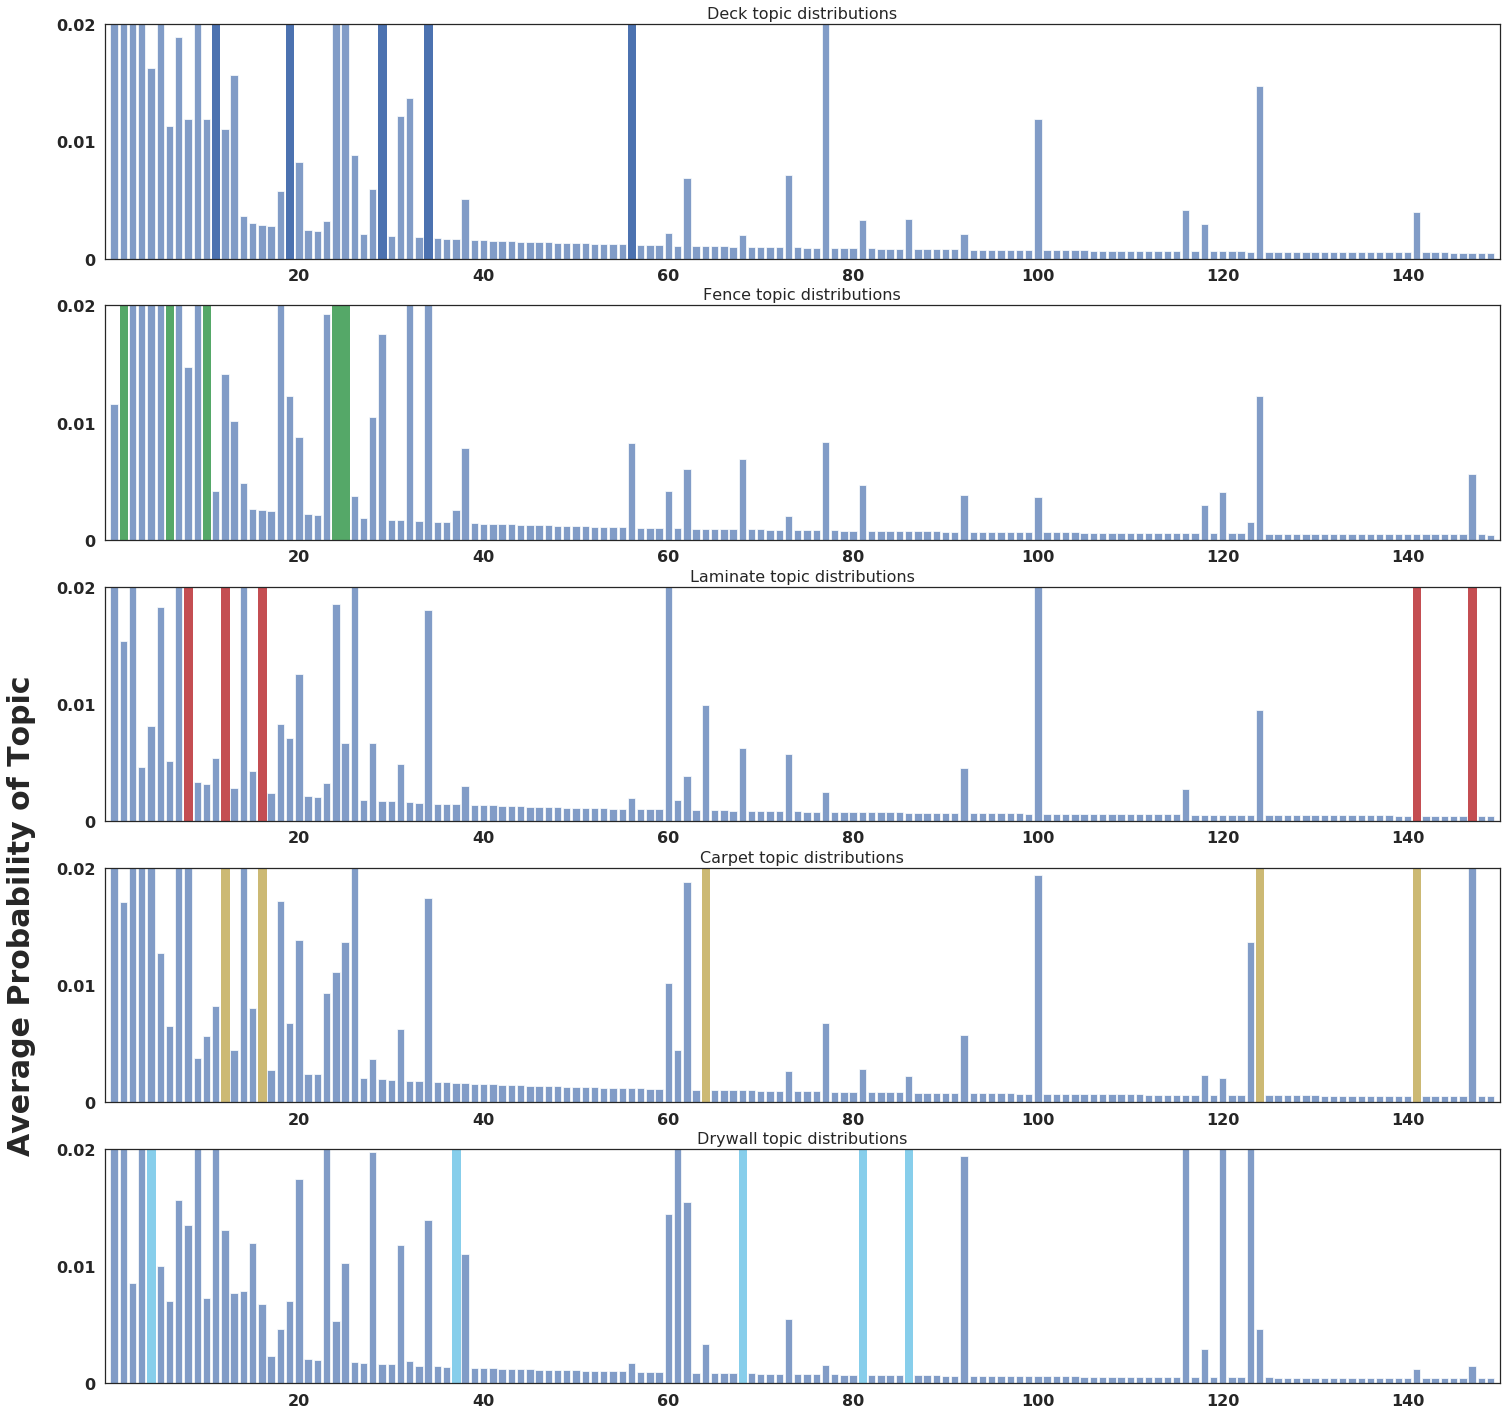

In [89]:
# visualize distribution plots for topics
fig, [ax1,ax2,ax3, ax4, ax5] = plt.subplots(5,1,figsize=(25,25))

nr_top_bars = 5

ax1.set_title("Deck topic distributions", fontsize=16)
ax2.set_title("Fence topic distributions", fontsize=16)
ax3.set_title("Laminate topic distributions", fontsize=16)
ax4.set_title("Carpet topic distributions", fontsize=16)
ax5.set_title("Drywall topic distributions", fontsize=16)
ax5.text(-10, 0.04, "Average Probability of Topic", fontsize=30, ha="center", va="center",
         rotation="vertical")

for ax, distribution, color in zip([ax1,ax2,ax3,ax4,ax5],
                                   [deck_topic_dist,
                                    fence_topic_dist,
                                    laminate_topic_dist,
                                    carpet_topic_dist,
                                    drywall_topic_dist],
                                   ['b','g','r','y','skyblue']):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, 150)
    ax.set_xticks(range(20,149,20))
    ax.set_xticklabels(range(20,149,20), fontsize=16)
    ax.set_ylim(0,0.02)
    ax.set_yticks([0,0.01,0.02])
    ax.set_yticklabels([0,0.01,0.02], fontsize=16)

fig.tight_layout(h_pad=1.)

#### Look at words the top topics contain

In [90]:
# function to gather the top topics for lda features
def get_topic_top_words(lda_model, topic_id, nr_top_words=5):
    """ Returns the top words for topic_id from lda_model.
    """
    id_tuples = lda_model.get_topic_terms(topic_id, topn=nr_top_words)
    word_ids = np.array(id_tuples)[:,0]
    words = map(lambda id_: lda_model.id2word[id_], word_ids)
    return words

In [91]:
# output the top topics
for category, distribution in zip(['Deck', 'Fence', 'Laminate', 'Carpet', 'Drywall'], 
                                  [deck_topic_dist,
                                   fence_topic_dist,
                                   laminate_topic_dist,
                                   carpet_topic_dist,
                                   drywall_topic_dist]):
    print("Looking up top words from top topics from {}.".format(category))
    for x in sorted(np.argsort(distribution)[-5:]):
        top_words = get_topic_top_words(LDAmodel, x)
        print("For topic {}, the top words are: {}.".format(x, ", ".join(top_words)))
    print("")

Looking up top words from top topics from Deck.
For topic 11, the top words are: frame, backyard, tool, deck, diy.
For topic 19, the top words are: outdoor, idea, home, great, make.
For topic 29, the top words are: deck, build, diy, guid, step.
For topic 34, the top words are: part, 1, rail, 2, build.
For topic 56, the top words are: build, deck, 5, design, 6.

Looking up top words from top topics from Fence.
For topic 1, the top words are: gate, fenc, patio, diy, hang.
For topic 6, the top words are: 4, fenc, panel, wooden, 10.
For topic 10, the top words are: post, fenc, easi, fast, cheap.
For topic 24, the top words are: wood, build, diy, chair, modern.
For topic 25, the top words are: fenc, make, new, old, look.

Looking up top words from top topics from Laminate.
For topic 8, the top words are: instal, video, lamin, trim, howto.
For topic 12, the top words are: floor, instal, vinyl, hardwood, stain.
For topic 16, the top words are: floor, lamin, instal, diy, plywood.
For topic 141

#### Visualizations for LDA -- not needed for training model -- END
-----------------

## Word2Vec

### Train

In [92]:
# show number of sentences and texts for w2v
sentences = []
for sentence_group in training_df.tokenized_sentences:
    sentences.extend(sentence_group)

print("Number of sentences: {}.".format(len(sentences)))
print("Number of texts: {}.".format(len(training_df)))

Number of sentences: 761.
Number of texts: 701.


In [93]:
%%time
# set values for various parameters
num_features = 200    # Word vector dimensionality
min_word_count = 2    # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 6           # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# initialize and train the model
W2Vmodel = Word2Vec(sentences=sentences,
                    sg=1,
                    hs=0,
                    workers=num_workers,
                    size=num_features,
                    min_count=min_word_count,
                    window=context,
                    sample=downsampling,
                    negative=5,
                    iter=6)

CPU times: user 93.2 ms, sys: 0 ns, total: 93.2 ms
Wall time: 97.4 ms


In [94]:
# function to convert a list of lists of words 
# to a feature vector for Word2Vec
def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    words = np.concatenate(sentence_group)  # words in text
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # initialize a counter for number of words in a review
    nwords = 0
    # loop over each word in the comment and, if it is in the model's 
    # vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

training_df['w2v_features'] = list(map(lambda sen_group: 
                                     get_w2v_features(W2Vmodel, sen_group),
                                     training_df.tokenized_sentences))

/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [95]:
#training_df.head(3)

-----------------
#### Visualizations for Word2Vec -- not needed for training model -- START

In [96]:
# compute mean of word2vec features for training data
deck_w2v_dist = training_df.loc[training_df.primary_category == 
                                'build_deck', 'w2v_features'].mean()

fence_w2v_dist = training_df.loc[training_df.primary_category == 
                                 'repair_wood_fence', 'w2v_features'].mean()

laminate_w2v_dist = training_df.loc[training_df.primary_category == 
                                    'laminate_flooring', 'w2v_features'].mean()

carpet_w2v_dist = training_df.loc[training_df.primary_category == 
                                  'carpet_flooring', 'w2v_features'].mean()

drywall_w2v_dist = training_df.loc[training_df.primary_category == 
                                   'drywall_repair', 'w2v_features'].mean()

/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


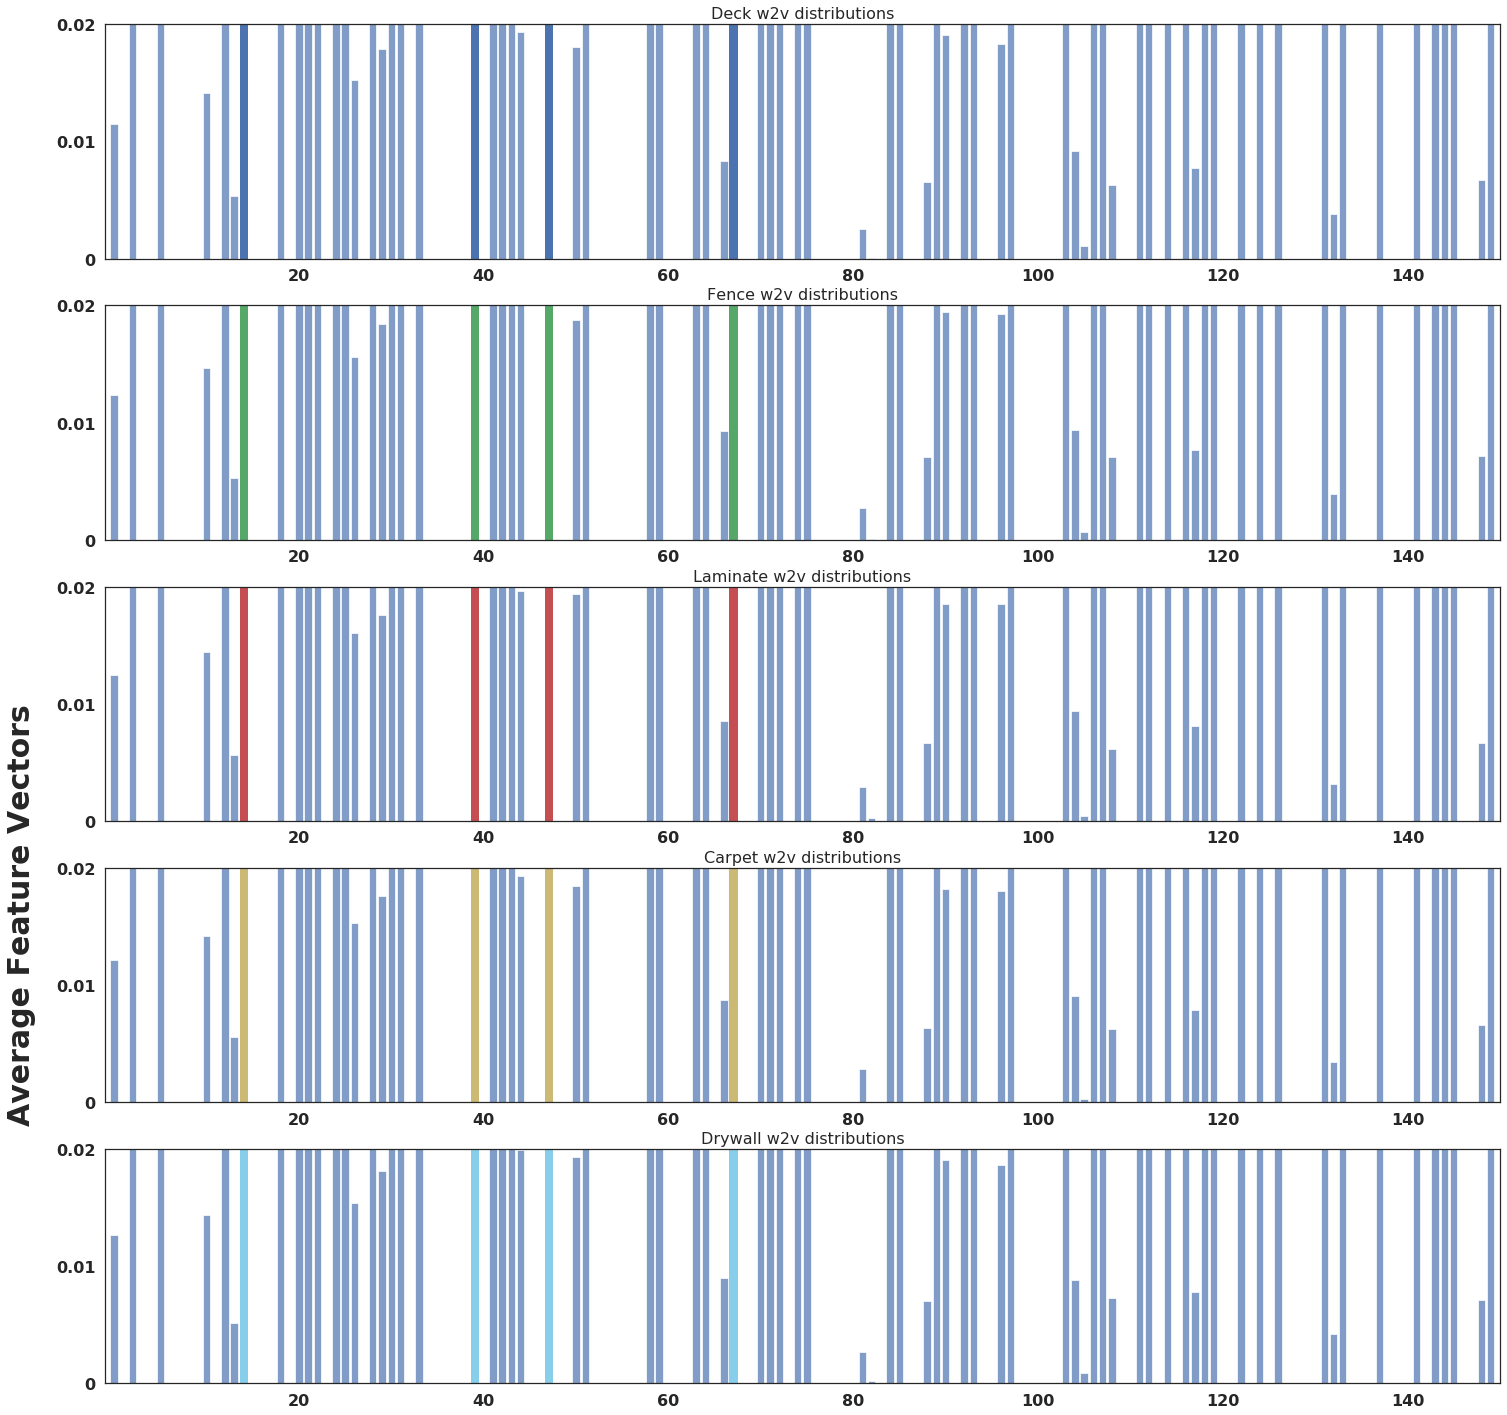

In [97]:
# visualize the distributions
fig, [ax1,ax2,ax3, ax4, ax5] = plt.subplots(5,1,figsize=(25,25))

nr_top_bars = 5

ax1.set_title("Deck w2v distributions", fontsize=16)
ax2.set_title("Fence w2v distributions", fontsize=16)
ax3.set_title("Laminate w2v distributions", fontsize=16)
ax4.set_title("Carpet w2v distributions", fontsize=16)
ax5.set_title("Drywall w2v distributions", fontsize=16)
ax5.text(-10, 0.04, "Average Feature Vectors", fontsize=30, ha="center", va="center",
         rotation="vertical")

for ax, distribution, color in zip([ax1,ax2,ax3,ax4,ax5],
                                   [deck_w2v_dist,
                                    fence_w2v_dist,
                                    laminate_w2v_dist,
                                    carpet_w2v_dist,
                                    drywall_w2v_dist],
                                   ['b','g','r','y','skyblue']):
    # individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)
    # general plotting adjustments
    ax.set_xlim(-1, 150)
    ax.set_xticks(range(20,149,20))
    ax.set_xticklabels(range(20,149,20), fontsize=16)
    ax.set_ylim(0,0.02)
    ax.set_yticks([0,0.01,0.02])
    ax.set_yticklabels([0,0.01,0.02], fontsize=16)

fig.tight_layout(h_pad=1.)

#### Visualizations for Word2Vec -- not needed for training model -- END
-----------------

### Classification and Hyperparameter Tuning

In [98]:
# encode the labels from e.g., 'drywall_repair' --> 0
label_encoder = LabelEncoder()

label_encoder.fit(training_df.primary_category)
training_df['category_id'] = label_encoder.transform(training_df.primary_category)

In [99]:
#training_df.tail(3)

In [100]:
# create first pipeline for base without reducing features
pipe = Pipeline([('classifier' , RandomForestClassifier())])

# create param grid.
param_grid = [{'classifier' : [LogisticRegression()], 
               'classifier__penalty' : ['l1', 'l2'],
               'classifier__C' : np.logspace(-4, 4, 20)},
              {'classifier' : [RandomForestClassifier()],
               'classifier__n_estimators' : list(range(10,101,10)),
               'classifier__max_features' : list(range(6,32,5))}]

In [101]:
# function to perform exhaustive cross validation and 
# identify the best model based on 'log_loss'
def get_cross_validated_model(model, param_grid, X, y, nr_folds=5):
    """ Trains a model by doing a grid search combined with cross validation.
    args:
        model: your model
        param_grid: dict of parameter values for the grid search
    returns:
        Model trained on entire dataset with hyperparameters chosen from best results in the grid search.
    """
    # train the model (since the evaluation is based on the logloss, we'll use neg_log_loss here)
    grid_cv = GridSearchCV(model, param_grid=param_grid, scoring='neg_log_loss', 
                           cv=nr_folds, n_jobs=-1, verbose=True)
    
    best_model = grid_cv.fit(X, y)
    
    # show top models with parameter values
    result_df = pd.DataFrame(best_model.cv_results_)
    show_columns = ['mean_test_score', 'rank_test_score']
    
    for col in result_df.columns:
        if col.startswith('param_'):
            show_columns.append(col)
    display(result_df[show_columns].sort_values(by='rank_test_score').head())
    return best_model

In [102]:
# training_df['lda_features'] and training_df['w2v_features'] don't 
# have the needed shape and type yet, need to transform every entry
X_train_lda = np.array(list(map(np.array, training_df.lda_features)))
X_train_w2v = np.array(list(map(np.array, training_df.w2v_features)))
X_train_combined = np.append(X_train_lda, X_train_w2v, axis=1)

In [103]:
# store all models in a dictionary
models = dict()

## Logistic Regression -- because working with log loss which requires predict_proba( )

In [104]:
## commented out because the model does not perform well enough

# # get best lda model
# best_lda = get_cross_validated_model(pipe, param_grid, X_train_lda, training_df.category_id)

# #models['best_lr_lda'] = best_lr_lda
# models['best_lda'] = best_lda

In [105]:
## model with best classification performance

# get best w2v model
best_w2v = get_cross_validated_model(pipe, param_grid, X_train_w2v, training_df.category_id)

#models['best_lr_w2v'] = best_lr_w2v
models['best_w2v'] = best_w2v

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 222 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 420 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.0min finished
/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify

,mean_test_score,rank_test_score,param_classifier,param_classifier__C,param_classifier__penalty,param_classifier__max_features,param_classifier__n_estimators
32,-0.552988,1,"LogisticRegression(C=545.5594781168514, class_...",545.559,l1,NaN,NaN
34,-0.592149,2,"LogisticRegression(C=545.5594781168514, class_...",1438.45,l1,NaN,NaN
30,-0.603340,3,"LogisticRegression(C=545.5594781168514, class_...",206.914,l1,NaN,NaN
39,-0.688385,4,"LogisticRegression(C=545.5594781168514, class_...",10000,l2,NaN,NaN
36,-0.717659,5,"LogisticRegression(C=545.5594781168514, class_...",3792.69,l1,NaN,NaN


In [106]:
## commented out because the model does not perform well enough

# # get best lda and w2v models combined
# best_combined = get_cross_validated_model(pipe, param_grid, X_train_combined, training_df.category_id)

# #models['best_lr_combined'] = best_lr_combined
# models['best_combined'] = best_combined

In [107]:
# output each models best score
for name, model in models.items():
    print("Model {} has a test score of: {:0.4f}".format(name, float(model.best_score_)))

Model best_w2v has a test score of: -0.5530


## Save best models

In [108]:
# save the model to disk
#lda_file = 'models/best_lda_model.pkl'
w2v_file = 'models/best_w2v_model_alt.pkl'
#combined_file = 'models/best_combined_model.sav'

In [109]:
#pickle.dump(models['best_lda'], open(lda_file, 'wb'))
pickle.dump(best_w2v, open(w2v_file, 'wb'))
#pickle.dump(models['best_combined'], open(combined_file, 'wb'))

----------------------
# Test Unseen Dataset and Validate Results

### Create new Dataframe of unseen data to Test model

In [110]:
# preprocess test data
lda_preprocessing(testing_df)
w2v_preprocessing(testing_df)

/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [111]:
testing_df.head(1)

,video_id,title,subtitles,primary_category,text,txt_len,summary,summary_len,prcnt_reduce,mentioned_tools,recommended_tools,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow,document_sentences,tokenized_sentences
1,1rAg4wW8ta0,how to carpet van interior panels - diy van ca...,all right well today Im going to be covering t...,carpet_flooring,Just shows you don't need a fancy arsed worksh...,2711,"How did you fix the panels, 🤙, screwed through...",476,82.441903,['square'],"['duckbill napping shears', 'carpet knife', 's...","[how, to, carpet, van, interior, panels, diy, ...","[carpet, van, interior, panels, diy, van, carp...","[carpet, van, interior, panel, diy, van, carpe...","[carpet, van, interior, panel, diy, van, carpe...","[(0, 2), (1, 1), (2, 1), (3, 1)]",[how to carpet van interior panels - diy van c...,"[[how, to, carpet, van, interior, panels, diy,..."


In [112]:
# testing_df['lda_features'] = list(map(lambda doc:
#                                      document_to_lda_features(LDAmodel, doc),
#                                      testing_df.bow.copy()))

testing_df['w2v_features'] = list(map(lambda sen_group:
                                     get_w2v_features(W2Vmodel, sen_group),
                                     testing_df.tokenized_sentences.copy()))

/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [113]:
testing_df.head(1)

,video_id,title,subtitles,primary_category,text,txt_len,summary,summary_len,prcnt_reduce,mentioned_tools,recommended_tools,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow,document_sentences,tokenized_sentences,w2v_features
1,1rAg4wW8ta0,how to carpet van interior panels - diy van ca...,all right well today Im going to be covering t...,carpet_flooring,Just shows you don't need a fancy arsed worksh...,2711,"How did you fix the panels, 🤙, screwed through...",476,82.441903,['square'],"['duckbill napping shears', 'carpet knife', 's...","[how, to, carpet, van, interior, panels, diy, ...","[carpet, van, interior, panels, diy, van, carp...","[carpet, van, interior, panel, diy, van, carpe...","[carpet, van, interior, panel, diy, van, carpe...","[(0, 2), (1, 1), (2, 1), (3, 1)]",[how to carpet van interior panels - diy van c...,"[[how, to, carpet, van, interior, panels, diy,...","[0.011102308, -0.012431706, 0.04290495, -0.021..."


In [114]:
testing_df.reset_index(inplace=True, drop=True)

In [115]:
testing_df[['video_id','primary_category','w2v_features']].head()

,video_id,primary_category,w2v_features
0,1rAg4wW8ta0,carpet_flooring,"[0.011102308, -0.012431706, 0.04290495, -0.021..."
1,2qAqFuo801U,carpet_flooring,"[0.011766241, -0.011496131, 0.038528517, -0.01..."
2,3-3gmCZm34E,carpet_flooring,"[0.010759739, -0.01153224, 0.03908579, -0.0191..."
3,4gUW-IhSMBc,carpet_flooring,"[0.012692319, -0.016277144, 0.050641395, -0.02..."
4,8AGMJGkbMSM,carpet_flooring,"[0.013985188, -0.01512159, 0.04951886, -0.0233..."


In [116]:
for feat in testing_df[testing_df.index == 256]['w2v_features']:
    #print(feat)
    continue

In [117]:
t_test = list(map(np.array, testing_df['w2v_features']))

In [118]:
np.array(t_test)

array([[ 0.01110231, -0.01243171,  0.04290495, ...,  0.02433202,
         0.0053365 ,  0.09363226],
       [ 0.01176624, -0.01149613,  0.03852852, ...,  0.02104439,
         0.00375232,  0.08502045],
       [ 0.01075974, -0.01153224,  0.03908579, ...,  0.02188788,
         0.00482663,  0.08689846],
       ...,
       [ 0.0148427 , -0.01527947,  0.04979928, ...,  0.02867531,
         0.00695665,  0.10898177],
       [ 0.0104244 , -0.01116752,  0.03883331, ...,  0.02235884,
         0.00500909,  0.08461171],
       [ 0.01248786, -0.01332258,  0.04486423, ...,  0.02461758,
         0.00639711,  0.09877115]], dtype=float32)

In [119]:
# training_df['lda_features'] and training_df['w2v_features'] don't 
# have the needed shape and type yet, need to transform every entry
#X_test_lda = np.array(list(map(np.array, test_data.lda_features)))
X_test_w2v = np.array(list(map(np.array, testing_df.w2v_features)))
#X_test_combined = np.append(X_test_lda, X_test_w2v, axis=1)

In [120]:
testing_df.w2v_features[0][0]

0.011102308

In [121]:
X_test_w2v

array([[ 0.01110231, -0.01243171,  0.04290495, ...,  0.02433202,
         0.0053365 ,  0.09363226],
       [ 0.01176624, -0.01149613,  0.03852852, ...,  0.02104439,
         0.00375232,  0.08502045],
       [ 0.01075974, -0.01153224,  0.03908579, ...,  0.02188788,
         0.00482663,  0.08689846],
       ...,
       [ 0.0148427 , -0.01527947,  0.04979928, ...,  0.02867531,
         0.00695665,  0.10898177],
       [ 0.0104244 , -0.01116752,  0.03883331, ...,  0.02235884,
         0.00500909,  0.08461171],
       [ 0.01248786, -0.01332258,  0.04486423, ...,  0.02461758,
         0.00639711,  0.09877115]], dtype=float32)

In [122]:
testing_df['category_id'] = label_encoder.transform(testing_df.primary_category.copy())
#testing_df.head(3)

/home/clutch/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [123]:
testing_df.head(1)

,video_id,title,subtitles,primary_category,text,txt_len,summary,summary_len,prcnt_reduce,mentioned_tools,recommended_tools,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow,document_sentences,tokenized_sentences,w2v_features,category_id
0,1rAg4wW8ta0,how to carpet van interior panels - diy van ca...,all right well today Im going to be covering t...,carpet_flooring,Just shows you don't need a fancy arsed worksh...,2711,"How did you fix the panels, 🤙, screwed through...",476,82.441903,['square'],"['duckbill napping shears', 'carpet knife', 's...","[how, to, carpet, van, interior, panels, diy, ...","[carpet, van, interior, panels, diy, van, carp...","[carpet, van, interior, panel, diy, van, carpe...","[carpet, van, interior, panel, diy, van, carpe...","[(0, 2), (1, 1), (2, 1), (3, 1)]",[how to carpet van interior panels - diy van c...,"[[how, to, carpet, van, interior, panels, diy,...","[0.011102308, -0.012431706, 0.04290495, -0.021...",1


In [124]:
label_encoder.classes_

array(['build_deck', 'carpet_flooring', 'drywall_repair',
       'laminate_flooring', 'repair_wood_fence'], dtype=object)

In [125]:
#best_lda.predict_proba(X_test_lda)

In [126]:
predictions = best_w2v.predict_proba(X_test_w2v)

In [127]:
predictions

array([[1.58438658e-01, 7.84333487e-01, 3.13882962e-02, 1.11169548e-02,
        1.47226041e-02],
       [4.69545318e-04, 8.87904212e-01, 3.74663205e-03, 1.07693236e-01,
        1.86374386e-04],
       [2.04323790e-01, 5.48105808e-01, 1.14314349e-01, 1.29660745e-01,
        3.59530793e-03],
       ...,
       [1.89958233e-03, 8.64863855e-06, 9.96473590e-01, 1.60538715e-03,
        1.27922975e-05],
       [2.84279819e-02, 4.03228471e-02, 8.72312141e-01, 1.55196285e-02,
        4.34174018e-02],
       [8.82601561e-03, 1.00213465e-02, 9.17319806e-01, 3.86963478e-03,
        5.99631969e-02]])

In [128]:
idx = testing_df.index[testing_df['video_id'] == '0jhqbnM-5XQ'].tolist()

In [129]:
predictions[idx]

array([[0.21781831, 0.490904  , 0.0333988 , 0.06915321, 0.18872568]])

In [130]:
#best_combined.predict_proba(X_test_combined)

## Output Training and Testing Data

In [131]:
# train_to_pkl_filename = 'data/csv_files/train_data.pkl'
# test_to_pkl_filename = 'data/csv_files/test_data.pkl'
# training_df.to_pickle(train_to_pkl_filename)
# testing_df.to_pickle(test_to_pkl_filename)

In [132]:
train_to_csv_filename = 'data/csv_files/train_data_alt.csv'
test_to_csv_filename = 'data/csv_files/test_data_alt.csv'
training_df.to_csv(train_to_csv_filename, sep=',')
testing_df.to_csv(test_to_csv_filename, sep=',')

In [133]:
train_to_pkl_filename = 'data/csv_files/train_data_alt.pkl'
test_to_pkl_filename = 'data/csv_files/test_data_alt.pkl'
training_df.to_pickle(train_to_pkl_filename)
testing_df.to_pickle(test_to_pkl_filename)

## START ATTEMPT TO LOCATE TOOLS IN SUBTITLES

In [1]:
%matplotlib inline

import os
import re
import numpy as np
import pandas as pd

In [2]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [3]:
from spacy.matcher import Matcher

In [4]:
m_tool = Matcher(nlp.vocab)

In [5]:
from_csv_filename = 'data/csv_files/summarized_data.csv'
data_df = pd.read_csv(from_csv_filename, sep=',')
data_df.head()

,video_id,title,subtitles,primary_category,text,txt_len,summary,summary_len,prcnt_reduce
0,09Q4JQ3p8yg,How to remove popcorn stipple ceiling,hi Shannon here from health improvements and t...,drywall_repair,"asmr **, I love you, Im here from Instagram lm...",90480,"Ines rivera meeeeeee, me, 🙋‍♀️guilty, me, ines...",656,99.274978
1,0Aip_xxpia4,How to install carpet tiles,were going to replace this tired old wall-to-w...,carpet_flooring,Interface do a product called tactiles which a...,2183,"If you're able to :), use a mover disc for fuc...",398,81.768209
2,0COOF3BwgKI,Fix small nail holes in walls fast and make th...,so you like to hang pictures on your wall if y...,drywall_repair,Glad I could help then. Be sure and subscribe...,8009,"We have drywall hanging tools, finishing tools...",658,91.784243
3,0J8q_Lsh4fU,Hog wire deck rail installation,hi im paul from Elkins diy.com today Im going ...,build_deck,"Thanks Naegling, off topic but where are u get...",8102,"Silicone in the crevices is a great idea, 사랑합니...",522,93.557146
4,0RuwaSU71rY,Replacing a section of drywall after a pipe leak,hi Im Mike Thompson last night was a bit of an...,drywall_repair,"Great Job , Mike Thompson, good instructional ...",4012,"Great job , mike thompson, good instructional ...",623,84.471585


In [6]:
p1=[{'LOWER':'duckbill napping shears'},{'LOWER':'duck bill'},{'LOWER':'napping'},{'LOWER':'shear'}]
p2=[{'LOWER':'heavy weight carpet roller'},{'LOWER':'carpet roller'},{'LOWER':'roller'}]
p3=[{'LOWER':'ear plug'},{'LOWER':'ear'},{'LOWER':'plug'}]
p4=[{'LOWER':'dust mask'},{'LOWER':'dust'},{'LOWER':'mask'}]
p5=[{'LOWER':'tongue & groove plier'},{'LOWER':'wrench'}]
p6=[{'LOWER':'gloves'},{'LOWER':'work gloves'}]
p7=[{'LOWER':'vise'},{'LOWER':'trimmer'}]
p8=[{'LOWER':'tapping block'},{'LOWER':'tongue and groove'}]
p9=[{'LOWER':'measuring tape'},{'LOWER':'tape measure'}]
p10=[{'LOWER':'power stretcher'},{'LOWER':'stretcher'}]
p11=[{'LOWER':'scissors'},{'LOWER':'screwdriver'}]
p12=[{'LOWER':'belt sander'},{'LOWER':'sander'}]
p13=[{'LOWER':'pry bar'},{'LOWER':'pry'}]
p14=[{'LOWER':'knee pad'},{'LOWER':'pad'}]
p15=[{'LOWER':'rubber mallet'},{'LOWER':'mallet'}]
p16=[{'LOWER':'post hole digger'},{'LOWER':'hole digger'}]
p17=[{'LOWER':'dead blow hammer'},{'LOWER':'dead bolt'}]
p18=[{'LOWER':'air compressor'},{'LOWER':'compressor'}]
p19=[{'LOWER':'wire stripper'}]
p20=[{'LOWER':'wall trimmer'}]
p21=[{'LOWER':'veneer cutter'}]
p22=[{'LOWER':'utility knife'}]
p23=[{'LOWER':'trowel'}]
p24=[{'LOWER':'torque wrench'}]
p25=[{'LOWER':'taping knife'}]
p26=[{'LOWER':'tap'}]
p27=[{'LOWER':'table saw'}]
p28=[{'LOWER':'stud finder'}]
p29=[{'LOWER':'stapler'}]
p30=[{'LOWER':'stair tool'}]
p31=[{'LOWER':'square'}]
p32=[{'LOWER':'sponge'}]
p33=[{'LOWER':'spatula'}]
p34=[{'LOWER':'spacers'}]
p35=[{'LOWER':'socket'}]
p36=[{'LOWER':'snips'}]
p37=[{'LOWER':'snap ring plier'}]
p38=[{'LOWER':'slip joint plier'}]
p39=[{'LOWER':'sledge hammer'}]
p40=[{'LOWER':'shovel'}]
p41=[{'LOWER':'seaming iron'}]
p42=[{'LOWER':'seam roller'}]
p43=[{'LOWER':'screw driver'}]
p44=[{'LOWER':'saws-all'}]
p45=[{'LOWER':'saw'}]
p46=[{'LOWER':'sand paper'}]
p47=[{'LOWER':'safety glasses'}]
p48=[{'LOWER':'router'}]
p49=[{'LOWER':'rotary hammer'}]
p50=[{'LOWER':'rivet tool'}]
p51=[{'LOWER':'right angle drill'}]
p52=[{'LOWER':'reciprocating saw'}]
p53=[{'LOWER':'ratchet'}]
p54=[{'LOWER':'putty knife'}]
p55=[{'LOWER':'punch'}]
p56=[{'LOWER':'power drill'}]
p57=[{'LOWER':'plumb bob'}]
p58=[{'LOWER':'plumb and square'}]
p59=[{'LOWER':'plier'}]
p60=[{'LOWER':'pipe wrench'}]
p61=[{'LOWER':'pencil'}]
p62=[{'LOWER':'panel saw'}]
p63=[{'LOWER':'oscillating saw'}]
p64=[{'LOWER':'orbital sander'}]
p65=[{'LOWER':'needle nose plier'}]
p66=[{'LOWER':'nail puller'}]
p67=[{'LOWER':'nail gun'}]
p68=[{'LOWER':'nail driver'}]
p69=[{'LOWER':'mud pan'}]
p70=[{'LOWER':'miter saw'}]
p71=[{'LOWER':'metal snips'}]
p72=[{'LOWER':'maul'}]
p73=[{'LOWER':'mason line'}]
p74=[{'LOWER':'machete'}]
p75=[{'LOWER':'linoleum knife'}]
p76=[{'LOWER':'lineman plier'}]
p77=[{'LOWER':'level'}]
p78=[{'LOWER':'knee kicker'}]
p79=[{'LOWER':'joint knife'}]
p80=[{'LOWER':'jigsaw'}]
p81=[{'LOWER':'jig'}]
p82=[{'LOWER':'jamb saw'}]
p83=[{'LOWER':'impact socket'}]
p84=[{'LOWER':'hex key'}]
p85=[{'LOWER':'hatchet'}]
p86=[{'LOWER':'hand saw'}]
p87=[{'LOWER':'hammer'}]
p88=[{'LOWER':'hammer staple'}]
p89=[{'LOWER':'hammer drill'}]
p90=[{'LOWER':'hack saw'}]
p91=[{'LOWER':'grommet'}]
p92=[{'LOWER':'glue gun'}]
p93=[{'LOWER':'glass cutter'}]
p94=[{'LOWER':'floor scraper'}]
p95=[{'LOWER':'file'}]
p96=[{'LOWER':'electric staple gun'}]
p97=[{'LOWER':'drilling hammer'}]
p98=[{'LOWER':'drill'}]
p99=[{'LOWER':'dividers'}]
p100=[{'LOWER':'deck screws'}]
p101=[{'LOWER':'cutting plier'}]
p102=[{'LOWER':'crimper'}]
p103=[{'LOWER':'clamp'}]
p104=[{'LOWER':'circular saw'}]
p105=[{'LOWER':'chop saw'}]
p106=[{'LOWER':'chalk'}]
p107=[{'LOWER':'chalk line'}]
p108=[{'LOWER':'caulking gun'}]
p109=[{'LOWER':'carpet tucker'}]
p110=[{'LOWER':'carpet row cutter'}]
p111=[{'LOWER':'carpet knife'}]
p112=[{'LOWER':'breaker bar'}]
p113=[{'LOWER':'bolt cutter'}]
p114=[{'LOWER':'band saw'}]
p115=[{'LOWER':'axe'}]
p116=[{'LOWER':'awl'}]
p117=[{'LOWER': 'side'}, {'LOWER': 'cutters'}]
p118=[{'LOWER': 'electrical'}, {'LOWER': 'tape'}]
p119=[{'LOWER': 'drill bit'}]
p120=[{'LOWER': 'paper towel'}, {'LOWER': 'papertowel'}]

In [7]:
m_tool.add('QBF',  None,  p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, 
           p12, p13, p14, p15, p16, p17, p18, p19, p20, p21, p22, p23, 
           p24, p25, p26, p27, p28, p29, p30, p31, p32, p33, p34, p35, 
           p36, p37, p38, p39, p40, p41, p42, p43, p44, p45, p46, p47, 
           p48, p49, p50, p51, p52, p53, p54, p55, p56, p57, p58, p59, 
           p60, p61, p62, p63, p64, p65, p66, p67, p68, p69, p70, p71, 
           p72, p73, p74, p75, p76, p77, p78, p79, p80, p81, p82, p83, 
           p84, p85, p86, p87, p88, p89, p90, p91, p92, p93, p94, p95, 
           p96, p97, p98, p99, p100, p101, p102, p103, p104, p105, p106, 
           p107, p108, p109, p110, p111, p112, p113, p114, p115, p116, 
           p117, p118, p119, p120)

In [8]:
sentence = nlp(data_df.subtitles[100])

In [9]:
#data_df.title[200]

In [10]:
#data_df.subtitles[200]

In [11]:
phrase_matches = m_tool(sentence)  
print(phrase_matches )

[(12825528024649263697, 35, 36), (12825528024649263697, 37, 39), (12825528024649263697, 42, 44), (12825528024649263697, 55, 56), (12825528024649263697, 279, 281)]


In [14]:
def check_tools(subtitles):
    list_of_tools = []
    sentence = nlp(subtitles)
    phrase_matches = m_tool(sentence)
    for match_id, start, end in phrase_matches:
        string_id = nlp.vocab.strings[match_id]
        span = sentence[start:end]
        list_of_tools.append(span.text)
    return list(set(list_of_tools))
    #print(match_id, string_id, start, end, span.text)

In [17]:
data_df['mentioned_tools'] = [check_tools(s.lower()) for s in data_df.subtitles]

In [18]:
data_df.head()

,video_id,title,subtitles,primary_category,text,txt_len,summary,summary_len,prcnt_reduce,mentioned_tools
0,09Q4JQ3p8yg,How to remove popcorn stipple ceiling,hi Shannon here from health improvements and t...,drywall_repair,"asmr **, I love you, Im here from Instagram lm...",90480,"Ines rivera meeeeeee, me, 🙋‍♀️guilty, me, ines...",656,99.274978,[square]
1,0Aip_xxpia4,How to install carpet tiles,were going to replace this tired old wall-to-w...,carpet_flooring,Interface do a product called tactiles which a...,2183,"If you're able to :), use a mover disc for fuc...",398,81.768209,"[chalk, square]"
2,0COOF3BwgKI,Fix small nail holes in walls fast and make th...,so you like to hang pictures on your wall if y...,drywall_repair,Glad I could help then. Be sure and subscribe...,8009,"We have drywall hanging tools, finishing tools...",658,91.784243,"[level, sponge]"
3,0J8q_Lsh4fU,Hog wire deck rail installation,hi im paul from Elkins diy.com today Im going ...,build_deck,"Thanks Naegling, off topic but where are u get...",8102,"Silicone in the crevices is a great idea, 사랑합니...",522,93.557146,"[square, tap, saw, drill, pencil, hammer]"
4,0RuwaSU71rY,Replacing a section of drywall after a pipe leak,hi Im Mike Thompson last night was a bit of an...,drywall_repair,"Great Job , Mike Thompson, good instructional ...",4012,"Great job , mike thompson, good instructional ...",623,84.471585,[saw]


In [19]:
complete_list_of_mentioned_tools = [tools for tools in data_df.mentioned_tools]

In [20]:
i=0
j=0
for t in complete_list_of_mentioned_tools:
    if len(t)==0:
        i+=1
    else:
        j+=1
print("Number of videos where tools NOT Mentioned: {}".format(i))
print("Number of videos where tools ARE Mentioned: {}".format(j))

Number of videos where tools NOT Mentioned: 217
Number of videos where tools ARE Mentioned: 820


In [21]:
data_df.head()

,video_id,title,subtitles,primary_category,text,txt_len,summary,summary_len,prcnt_reduce,mentioned_tools
0,09Q4JQ3p8yg,How to remove popcorn stipple ceiling,hi Shannon here from health improvements and t...,drywall_repair,"asmr **, I love you, Im here from Instagram lm...",90480,"Ines rivera meeeeeee, me, 🙋‍♀️guilty, me, ines...",656,99.274978,[square]
1,0Aip_xxpia4,How to install carpet tiles,were going to replace this tired old wall-to-w...,carpet_flooring,Interface do a product called tactiles which a...,2183,"If you're able to :), use a mover disc for fuc...",398,81.768209,"[chalk, square]"
2,0COOF3BwgKI,Fix small nail holes in walls fast and make th...,so you like to hang pictures on your wall if y...,drywall_repair,Glad I could help then. Be sure and subscribe...,8009,"We have drywall hanging tools, finishing tools...",658,91.784243,"[level, sponge]"
3,0J8q_Lsh4fU,Hog wire deck rail installation,hi im paul from Elkins diy.com today Im going ...,build_deck,"Thanks Naegling, off topic but where are u get...",8102,"Silicone in the crevices is a great idea, 사랑합니...",522,93.557146,"[square, tap, saw, drill, pencil, hammer]"
4,0RuwaSU71rY,Replacing a section of drywall after a pipe leak,hi Im Mike Thompson last night was a bit of an...,drywall_repair,"Great Job , Mike Thompson, good instructional ...",4012,"Great job , mike thompson, good instructional ...",623,84.471585,[saw]


In [16]:
data_df.mentioned_tools[100]

['electrical tape', 'drill', 'side cutters']

### Create Recommended Tools by Subtracting Sets

In [17]:
carpet_tools = ['carpet knife','carpet row cutter','carpet tucker','duckbill napping shears',
                'electric staple gun','floor scraper','hammer staple','heavy weight carpet roller',
                'knee kicker','knee pads','linoleum knife','measuring tape','pencil','power stretcher',
                'seam roller','seaming iron','stair tool','stapler','wall trimmer','work gloves']

laminate_tools = ['chalk line','circular saw','dead blow hammer','dividers','drill','floor scraper',
                  'hammer','hand saw','jigsaw','knee pads','level','measuring tape','miter saw',
                  'pencil','pull bar','router','spacers','square','table saw','tapping block',
                  'utility knife','work gloves','ear plug','tapping block','rubber mallet']

deck_tools = ['air compressor','belt sander','chalk line','chop saw','circular saw','clamps','deck screws',
              'drill','hammer','hand saw','jigsaw','level','measuring tape','nail gun','nail puller',
              'oscillating saw','pencil','pliers','plumb and square','post hole digger','pry bar',
              'reciprocating saw','router','safety glasses','shovel','square','table saw',
              'utility knife','work gloves','wrench']

fence_tools = ['air compressor','chalk','circular saw','deck screws','drill','hammer','level',
               'mason line','measuring tape','miter saw','plumb bob','post hole digger',
               'safety glasses','screwdriver','shovel','sledge hammer','table saw','work gloves']

drywall_tools = ['drill','drywall tape','dust mask','hammer','joint knife','measuring tape','mud pan',
                 'pencil','putty knife','safety glasses','sand paper','screwdriver','sponge','square',
                 'taping knife','utility knife','work gloves']

In [18]:
data_df.title[100]

'Laminate flooring repair to fix soft spot for uneven underlayment'

In [19]:
test_set = set(data_df.mentioned_tools[100])
test_set

{'drill', 'electrical tape', 'side cutters'}

In [20]:
laminate_set = set(laminate_tools)
#laminate_set

In [21]:
recommend_set = laminate_set - test_set
#recommend_set

In [22]:
carpet_df = data_df[data_df.primary_category=='carpet_flooring'].copy()
len(carpet_df)

151

In [23]:
laminate_df = data_df[data_df.primary_category=='laminate_flooring'].copy()
len(laminate_df)

186

In [24]:
fence_df = data_df[data_df.primary_category=='repair_wood_fence'].copy()
len(fence_df)

201

In [25]:
deck_df = data_df[data_df.primary_category=='build_deck'].copy()
len(deck_df)

209

In [26]:
drywall_df = data_df[data_df.primary_category=='drywall_repair'].copy()
len(drywall_df)

290

In [27]:
carpet_df['recommended_tools'] = [list(set(carpet_tools)-set(mt)) for mt in carpet_df.mentioned_tools]

In [28]:
laminate_df['recommended_tools'] = [list(set(laminate_tools)-set(mt)) for mt in laminate_df.mentioned_tools]

In [29]:
fence_df['recommended_tools'] = [list(set(fence_tools)-set(mt)) for mt in fence_df.mentioned_tools]

In [30]:
deck_df['recommended_tools'] = [list(set(deck_tools)-set(mt)) for mt in deck_df.mentioned_tools]

In [31]:
drywall_df['recommended_tools'] = [list(set(drywall_tools)-set(mt)) for mt in drywall_df.mentioned_tools]

In [35]:
result_df = pd.concat([carpet_df, laminate_df, fence_df, deck_df, drywall_df], ignore_index=True, sort=False)

In [37]:
result_df['mentioned_tools'] = result_df.mentioned_tools.apply(lambda x: x[1:-1].split(", "))
result_df['recommended_tools'] = result_df.recommended_tools.apply(lambda x: x[1:-1].split(", "))

AttributeError: 'list' object has no attribute 'split'

In [ ]:
to_csv_filename = 'data/csv_files/summarized_with_tools.csv'
result_df.to_csv(to_csv_filename, sep=',', index=False)

## END SEARCH FOR TOOLS

## Search Query

In [ ]:
cols = ['primary_category', 'title']
df = data_df[cols].copy()
df.info()

In [ ]:
df[(df.primary_category=='laminate_flooring') | (df.primary_category=='carpet_flooring')].sort_values('title', ascending=True).head()

In [ ]:
df.drop_duplicates(subset='title', keep="last", inplace=True)

In [ ]:
df.info()

In [ ]:
def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return len(intersection)/len(union)

In [ ]:
def cosine_distance_countvectorizer_method(s1, s2):
    
    # sentences to list
    allsentences = [s1 , s2]
    
    # packages
    from sklearn.feature_extraction.text import CountVectorizer
    from scipy.spatial import distance
    
    # text to vector
    vectorizer = CountVectorizer()
    all_sentences_to_vector = vectorizer.fit_transform(allsentences)
    text_to_vector_v1 = all_sentences_to_vector.toarray()[0].tolist()
    text_to_vector_v2 = all_sentences_to_vector.toarray()[1].tolist()
    
    # distance of similarity
    cosine = distance.cosine(text_to_vector_v1, text_to_vector_v2)
    #print('Similarity of two sentences are equal to ',round((1-cosine)*100,2),'%')
    return cosine

In [ ]:
search = "How to repair drywall"

In [ ]:
result = jaccard_similarity(search, df.title)

In [ ]:
df['cos_sim'] = [cosine_distance_countvectorizer_method(search,t) for t in df.title]

In [ ]:
df.sort_values('cos_sim', ascending=False).title.head()

In [ ]:
[t for t in df.title if 'mr' in t]

In [ ]:
gloveFile = "models/glove.42B.300d.txt"
import numpy as np
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    with open(gloveFile, encoding="utf8" ) as f:
        content = f.readlines()
    model = {}
    for line in content:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd

def preprocess(raw_text):

    # keep only words
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convert to lower case and split 
    words = word_tokenize(letters_only_text.lower())

    # remove stopwords
    stop_words = stopwords.words("english")
    newStopWords = ['mryoucandoityourself', 'locksolid', 'petproof', 'tackstrip', 
                    'reflooring', 'drywallrepair', 'buildipedia', 'corefix', 'ghtl', 
                    'patreon', 'kraftmade', 'eztexture', 'renovision', 'yugipedia', 
                    'savogran', 'fibafuse', 'redbrand', 'how', 'to']
    stop_words.extend(newStopWords)
    stopword_set = set(stop_words)
    
    cleaned_words = set([w for w in words if w not in stopword_set])

    return cleaned_words

def cosine_distance_between_two_words(word1, word2):
    import scipy
    return (1- scipy.spatial.distance.cosine(model[word1], model[word2]))

def calculate_heat_matrix_for_two_sentences(s1,s2):
    s1 = preprocess(s1)
    s2 = preprocess(s2)
    result_list = [[cosine_distance_between_two_words(word1, word2) for word2 in s2] for word1 in s1]
    result_df = pd.DataFrame(result_list)
    result_df.columns = s2
    result_df.index = s1
    return result_df

def cosine_distance_wordembedding_method(s1, s2):
    import scipy
    vector_1 = np.mean([model[word] for word in preprocess(s1)],axis=0)
    vector_2 = np.mean([model[word] for word in preprocess(s2)],axis=0)
    cosine = scipy.spatial.distance.cosine(vector_1, vector_2)
    print('Word Embedding method with a cosine distance assess that our two sentences are similar to',round((1-cosine)*100,2),'%')

def heat_map_matrix_between_two_sentences(s1,s2):
    df = calculate_heat_matrix_for_two_sentences(s1,s2)
    import seaborn as sns
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(5,5)) 
    ax_blue = sns.heatmap(df, cmap="YlGnBu")
    # ax_red = sns.heatmap(df)
    print(cosine_distance_wordembedding_method(s1, s2))
    return ax_blue

In [ ]:
def compute_similarity(search, title):
    l1 =[];l2 =[]
    s1 = preprocess(search)
    t1 = preprocess(title)
    # form a set containing keywords of both strings  
    rvector = s1.union(t1)  
    for w in rvector: 
        if w in s1: l1.append(1) # create a vector 
        else: l1.append(0) 
        if w in t1: l2.append(1) 
        else: l2.append(0) 
    c = 0
    # cosine formula  
    for i in range(len(rvector)): 
            c+= l1[i]*l2[i] 
    cos_sim = c / float((sum(l1)*sum(l2))**0.5) 
    return cos_sim

In [ ]:
import scipy
from sklearn.metrics.pairwise import cosine_similarity
search = "How to install laminate flooring"
df['cos_sim'] = [compute_similarity(search,t) for t in df.title]

In [ ]:
df.sort_values('cos_sim', ascending=False).head(10)

In [ ]:
ss1 = 'How to repair a hole in the wall'
ss2 = 'How to repair damaged drywall paper- torn drywall'
ss3 = 'How to install laminate flooring'

In [ ]:
cosine_distance_countvectorizer_method(ss1 , ss3)

In [ ]:
model = loadGloveModel(gloveFile)

In [ ]:
heat_map_matrix_between_two_sentences(ss1,ss3)